In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.9 MB/s 


In [ ]:
pip install -U nltk

     |████████████████████████████████| 1.5 MB 5.8 MB/s 
     |████████████████████████████████| 749 kB 53.5 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
from scipy import stats
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import PlaintextCorpusReader
from datetime import datetime
import re
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
from sklearn.decomposition import PCA

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from collections import Counter

nlp = spacy.load('en')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Index
1. Preparation of the data
2. General analysis of differences between parties
3. Immigration analysis: focus on non-neutral words of quotes
4. Climate change analysis: focus on whole quotes (not conclusive)
5. Generalise analysis using lexical fields and on gun policies and healthcare

# 1. Prepare the data

In [ ]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
df_congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv") #Uncomment to use Drive data
# df_congress = pd.read_csv("../dataset_extraction/congress_115_116.csv")

In [ ]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv")

In [ ]:
# Republican congress
congress = congress[~(congress["party"] == "ID")]
republicans = congress[congress["party"] == "R"]
print(congress['party'].value_counts())
republicans.head()

D    198
R    188
Name: party, dtype: int64


,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
0,0,H4LA05221,ralph abraham,Rep.,Abraham,Ralph,R,1954-09-16,M,LA
2,2,H6AL04098,robert aderholt,Rep.,Aderholt,Robert,R,1965-07-22,M,AL
4,4,H2GA12121,rick allen,Rep.,Allen,Rick,R,1951-11-07,M,GA
5,5,H0MI03126,justin amash,Rep.,Amash,Justin,R,1980-04-18,M,MI
6,6,H2NV02395,mark amodei,Rep.,Amodei,Mark,R,1958-06-12,M,NV


In [ ]:
# Democratic congress
democrats = congress[congress["party"] == "D"]
democrats.head()

,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
1,1,H4NC12100,alma adams,Rep.,Adams,Alma,D,1946-05-27,F,NC
3,3,H2CA31125,pete aguilar,Rep.,Aguilar,Pete,D,1979-06-19,M,CA
12,12,H6CA44103,nanette barragán,Rep.,Barragán,Nanette,D,1976-09-15,F,CA
13,13,H0CA33117,karen bass,Rep.,Bass,Karen,D,1953-10-03,F,CA
14,14,H2OH03125,joyce beatty,Rep.,Beatty,Joyce,D,1950-03-12,F,OH


In [ ]:
# Load data with respect to given year 
quotes_congress = []
def loadDataYear(years):
  # link to the Drive repo + the year of the newpapers quotes
  for j, year in enumerate(years_data):
    path_to_file = f'/content/drive/MyDrive/ADA/quotes-{year}-congress-speakers.json.bz2'
    # here the data is in the ADA folder placed at the root of your Drive
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, sample in enumerate(s_file):
          quote = json.loads(sample)
          quotes_congress.append(quote)

In [ ]:
%%time 
#  Load data given year 
years_data = ["2016","2017","2018","2019","2020"]
loadDataYear(years_data)

CPU times: user 1min 50s, sys: 3.69 s, total: 1min 54s
Wall time: 2min 1s


In [ ]:
# Transforming the array of quotes in a pandas DataFrame
# Display dataframe
df_quotes = pd.DataFrame(quotes_congress)
df_quotes.head()

# Then create a new dataframe df with the political affiliation of speaker
df = df_quotes
df['speaker'] = df['speaker'].str.lower() #puts all strings in lower cases
df_congress_new = congress[['party','speaker','date_of_birth','gender','state']].copy()
df = df.merge(df_congress_new, how = 'left', on='speaker')

# Convert date object to datetime and delete independant party
df["date"]= pd.to_datetime(df['date'])
df = df[~df['party'].isin(['ID'])]

#Simplify df to reduce computation time
df.drop(['qids', 'probas','urls'], axis=1)
df.dtypes
df["quotation"].astype('unicode')

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,date_of_birth,gender,state
0,2016-07-21-005544,"All the police officers that we work with, we ...",frederica wilson,[Q461504],2016-07-21 17:01:00,1,"[[Frederica Wilson, 0.8788], [None, 0.1212]]",[http://www.washingtontimes.com/news/2016/jul/...,E,D,1942-11-05,F,FL
1,2016-07-23-004668,"As a former Christian missionary, faith is cen...",tim kaine,[Q359888],2016-07-23 18:06:44,8,"[[Tim Kaine, 0.5755], [None, 0.2272], [Larry R...",[https://www.buzzfeed.com/andrewkaczynski/list...,E,D,1958-02-26,M,VA
2,2016-09-09-010924,bad bill that would put Americans' savings and...,maxine waters,[Q461727],2016-09-09 21:58:45,6,"[[Maxine Waters, 0.922], [None, 0.0728], [Jim ...",[http://thehour.com/business/article/Himes-fav...,E,D,1938-08-15,F,CA
3,2016-09-28-013218,"Better deal how? What exactly is your idea, Do...",elizabeth warren,[Q434706],2016-09-28 08:34:00,2,"[[Elizabeth Warren, 0.5615], [None, 0.3314], [...",[http://www.politico.com/story/2016/09/warren-...,E,D,1949-06-22,F,MA
4,2016-05-02-010790,"But that's the free market,",seth moulton,[Q18045052],2016-05-02 19:11:11,2,"[[Seth Moulton, 0.3773], [None, 0.2566], [Dona...",[http://gloucestertimes.com/news/local_news/mo...,E,D,1978-10-24,M,MA


# 2. General visualisation of differences between parties

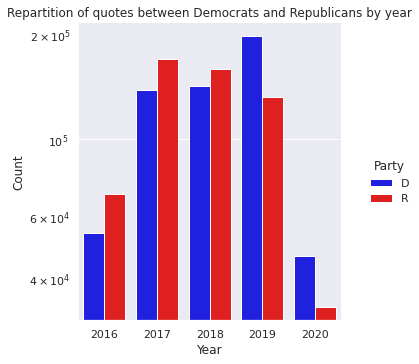

In [ ]:
#Plot distribution of quotes per party per year

#Extract year and create a new data frame with grouped quotes per year
df['Year'] = df['date'].apply(lambda x: "%.0f" % (x.year))
df_year = pd.DataFrame(df.groupby(['Year', 'party']).size(), columns=["Count"])
df_year["Year"] = df_year.index.get_level_values(0)
df_year["Party"] = df_year.index.get_level_values(1)
df_year = df_year[df_year.Year != "nan"]

# Bar plot of quotes number according to party per year
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.catplot(data=df_year, kind="bar", x="Year", y="Count", hue="Party", palette=sns.color_palette(['blue', 'red']))
ax.set(yscale="log")
ax.set(title="Repartition of quotes between Democrats and Republicans by year")
ax.savefig('DR_year.png')

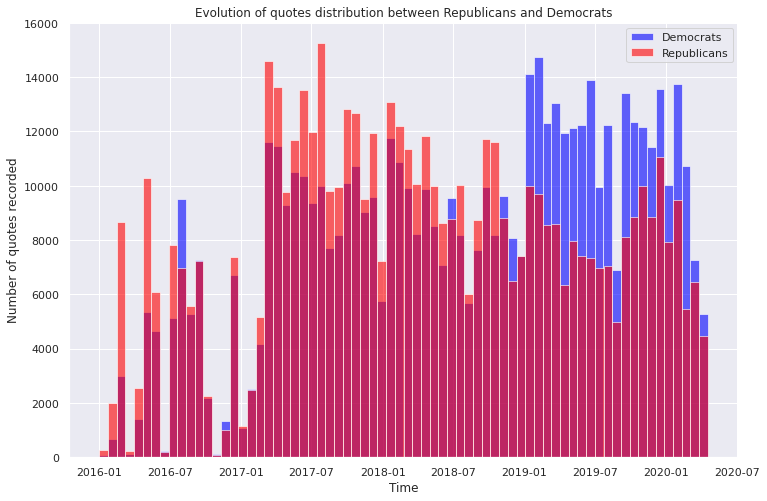

In [ ]:
#Histogram of quotes distribution versus time, for each party
ax = df["date"][df["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df["date"][df["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Evolution of quotes distribution between Republicans and Democrats")
ax.set(xlabel='Time', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()
ax.figure.savefig('DR_year.png')

# 3. Model and training 


In [ ]:
# Creation of function to generalise the process

def quotes_analysis(lex_field,subject):
    
    #Retrieve quotes that contain a certain lexical field and plot distribution for both parties
    df_subject = df[df['quotation'].str.contains('|'.join(lex_field))]
    print(f"Number of quotes around the word \'{subject}\' is {df_subject.shape[0]}")

    ax = df_subject["date"][df_subject["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
    ax = df_subject["date"][df_subject["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

    plt.title("Evolution of distribution of quotes containing %s between Republicans and Democrats" %subject)
    ax.set(xlabel='Time', ylabel='Number of quotes recorded')
    ax.legend(['Democrats','Republicans'])
    plt.show()
    ax.figure.savefig(subject + '.png')
    
    #Compute the percentage of subject quotes for each party 
    count_total_quotes = []
    count_total_quotes = [df.party.value_counts()['D'], df.party.value_counts()['R']] 
    ratio_data = df_subject['party'].value_counts()/count_total_quotes*100
    print("Percentage of quotes that contains the word %s :" %subject)
    print(ratio_data)
    
    return df_subject

Immigration


Number of quotes around the word 'immigration' is 1977


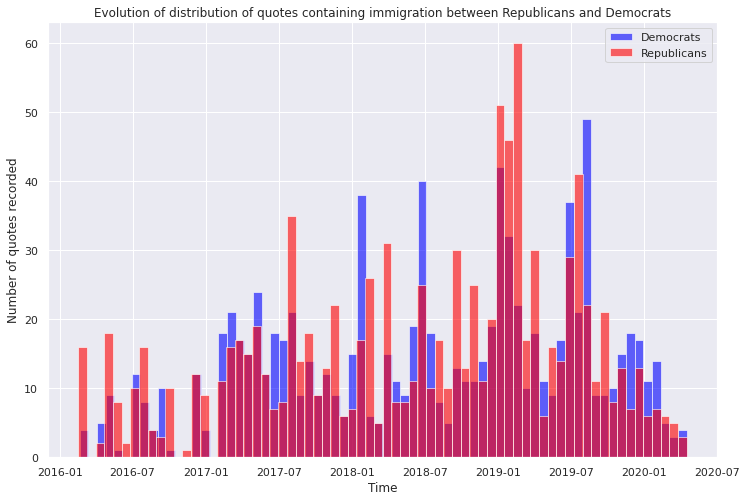

Percentage of quotes that contains the word immigration :
R    0.179625
D    0.165239
Name: party, dtype: float64


In [ ]:
lex_field_imm = ["Immigration","Immigrant","Immigrate","Influx of immigrants","First generation immigrant","Immigrant Community/Population",
                 "Migrant","Economic Migrant","Flood of Migrants","Chain Migration","Voluntary Migration","Forced migration",
                 "International Migration","Interregional Migration","Migration","Migrant Labor","Emigration","Permanent Resident",
                 "Temporary Resident","Undocumented","Illegal immigrant","Repatriation","Resettlement","Colonization", "Refugee", 
                 "Refugee Status", "Refugee Crisis", "Refugee Claimant", "Resettled Refugee", "Refugee Camp", "Political Refugee", 
                 "Economic Refugee", "Refugee Flow", "UNHCR (United Nations High Commissioner for Refugees)", "Internally Displaced Person", 
                 "Asylum", "An Asylum-Seeker", "Stateless person", "Humanitarian", "Aid", "Flee", "Terror", "Human rights", "Border", "Barrier", 
                 "Smuggling", "Trafficker", "Deportation"]

# filtering quotes
df_imm = quotes_analysis(lex_field_imm,'immigration')

Climate change

Number of quotes around the word 'climate' is 5844


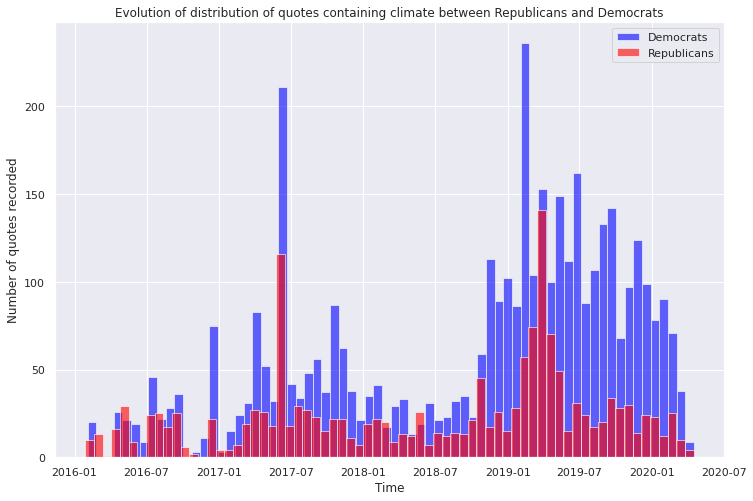

Percentage of quotes that contains the word climate :
D    0.718155
R    0.288814
Name: party, dtype: float64


In [ ]:
lex_field_climate = ["climate","climate change","Fossil Fuel", "Coal", "Oil", "Greenhouse Gas", "Carbon Dioxide", "Ozone", 
                     "Global Warming", "Greenhouse effect", "Extreme Weather Event", "Carbon Footprint", "Adaptation", "Mitigation", 
                     "Pollutant", "Drought" , "Renewable Resource", "Climate", "Habitat", "Ecosystem", "Weather", "Precipitation", 
                     "Global climate", "Methane"]

df_climate = quotes_analysis(lex_field_climate,'climate')

Healthcare

Number of quotes around the word 'healthcare' is 18518


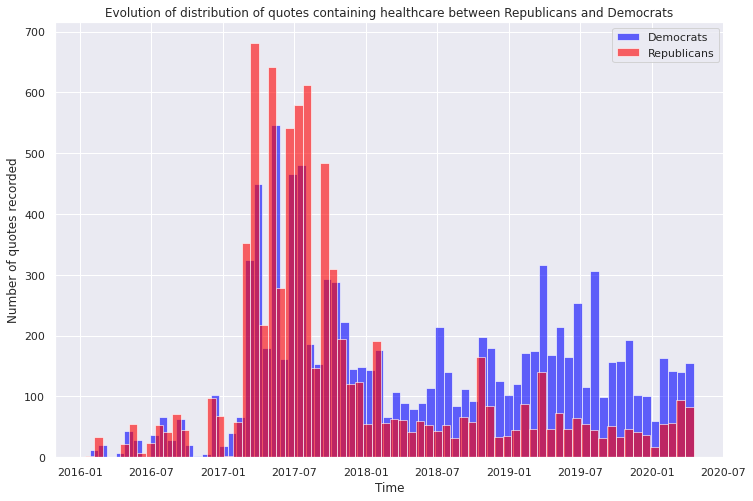

Percentage of quotes that contains the word healthcare :
D    1.76202
R    1.45471
Name: party, dtype: float64


In [ ]:
# Healthcare
lex_field_healthcare = ["healthcare","health care","health insurance","health maintenance","social insurance","medicare",
                        "medicaid","obamacare","affordable care act","patient protection","healthcare system","insurance coverage"                        
                        ]
df_health = quotes_analysis(lex_field_healthcare,'healthcare')

Gun policy


Number of quotes around the word 'gun policy' is 10113


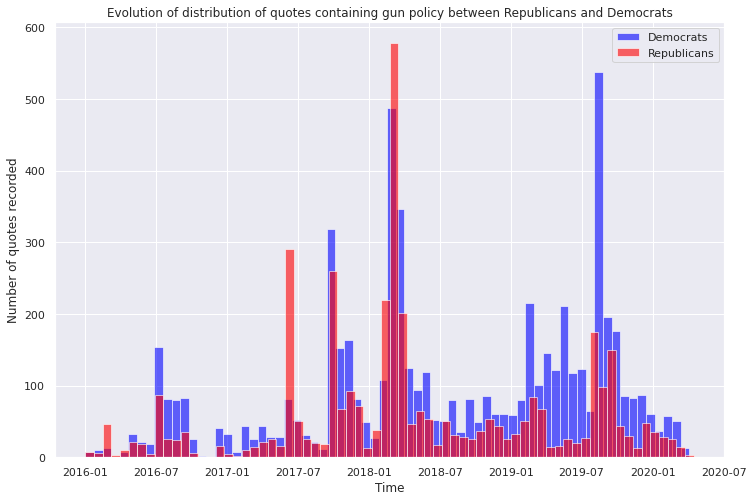

Percentage of quotes that contains the word gun policy :
D    1.077405
R    0.678687
Name: party, dtype: float64


In [ ]:
# Gun policy
lex_field_gunpolicy = ["gunlaw","gun policy","gun violence","gun control","gun license","gun",                        
                       "firearm","rifle","revolver","gun ownership","gun debate","gun law","firearms regulation"
                        ]

df_gun = quotes_analysis(lex_field_gunpolicy,'gun policy')

## Predominant words that characterises a party on a choosen subject

In [ ]:
republicans=congress[congress["party"] == "R"]["speaker"]
democrats=congress[congress["party"] == "D"]["speaker"]

In [ ]:
dems_quotes=np.array(df[df["speaker"].isin(democrats)]["quotation"])
reps_quotes=np.array(df[df["speaker"].isin(republicans)]["quotation"])

print(f"Number of democrats quotes : {len(dems_quotes)}")
print(f"Number of republicans quotes : {len(reps_quotes)}")

Number of democrats quotes : 578427
Number of republicans quotes : 564030


In [ ]:
def getQuotesLexicalField(lex_field):

  lex_field = np.array([x.lower() if isinstance(x, str) else x for x in lex_field])

  #Removing stopwords from the lexical field  
  stopwords = nltk.corpus.stopwords.words("english")
  lex_field = [w for w in lex_field if w.lower() not in stopwords]

  # Extracting lexical field from the dataset 

  set_lf = set(lex_field)
  dems_q_lf = [quote for quote in dems_quotes if(set_lf.intersection(set(quote.split())))]
  reps_q_lf = [quote for quote in reps_quotes if(set_lf.intersection(set(quote.split())))]

  return dems_q_lf, reps_q_lf

In [23]:
dems_q_healthcare, reps_q_healthcare = getQuotesLexicalField(lex_field_healthcare)

In [24]:
dems_q_climate, reps_q_climate = getQuotesLexicalField(lex_field_climate)

In [25]:
dems_q_gunpolicy, reps_q_gunpolicy = getQuotesLexicalField(lex_field_gunpolicy)

In [26]:
dems_q_imm, reps_q_imm = getQuotesLexicalField(lex_field_imm)

In [27]:
def save_to_file(array,path):

  file = open(path, "w+")
 
  # Saving the array in a text file
  content = str(array)
  file.write(content)
  file.close()
 
  # Displaying the contents of the text file
  file = open(path, "r")
  content = file.read()
 
  file.close()

In [28]:
def saveToFileQuotesLexicalField(dems_q_lf, reps_q_lf, idx_lf):
  path_dems=f'/content/drive/MyDrive/ADA/input_data/{lexical_field_str[idx_lf]}/dems_quotes_{lexical_field_str[idx_lf]}.txt'
  path_reps=f'/content/drive/MyDrive/ADA/input_data/{lexical_field_str[idx_lf]}/reps_quotes_{lexical_field_str[idx_lf]}.txt'

  save_to_file(dems_q_lf, path_dems)

  save_to_file(reps_q_lf, path_reps)

In [30]:
healthcare_idx = 0
gun_policy_idx = 1
climate_change_idx = 2
immigration_idx = 3

In [32]:
lexical_field_str = ["healthcare", "gun policy", "climate change", "immigration"]

In [33]:
saveToFileQuotesLexicalField(dems_q_healthcare, reps_q_healthcare, healthcare_idx)
saveToFileQuotesLexicalField(dems_q_climate, reps_q_climate, climate_change_idx)
saveToFileQuotesLexicalField(dems_q_gunpolicy, reps_q_gunpolicy, gun_policy_idx)
saveToFileQuotesLexicalField(dems_q_imm, reps_q_imm, immigration_idx)

## Training the model and testing it 

In [34]:
# Let's load our corpus via NLTK this time
def getDataQuotesLexicalField(idx_lf):
  corpus_path=f'/content/drive/MyDrive/ADA/input_data/{lexical_field_str[idx_lf]}'
  quotes_lf = PlaintextCorpusReader(corpus_path, '.*.txt')
  print(quotes_lf.fileids())

  return quotes_lf

In [35]:
quotes_healthcare = getDataQuotesLexicalField(healthcare_idx)
quotes_gunpolicy = getDataQuotesLexicalField(gun_policy_idx)
quotes_climate = getDataQuotesLexicalField(climate_change_idx)
quotes_imm = getDataQuotesLexicalField(immigration_idx)

['dems_quotes_healthcare.txt', 'reps_quotes_healthcare.txt']
['dems_quotes_gun policy.txt', 'reps_quotes_gun policy.txt']
['dems_quotes_climate change.txt', 'reps_quotes_climate change.txt']
['dems_quotes_immigration.txt', 'reps_quotes_immigration.txt']


In [36]:
def getChunkFromQuotes(quotes):
  def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


  # Get the data
  quotes_id = {f:n for n,f in enumerate(quotes.fileids())} # We get the dictionary of quotes

  chunks = list()
  chunk_class = list() # this list contains the original party quotes (republican or democrat) of the chunk, for evaluation

  limit = 500 # Number of total chunks

  size = 50 # Number of sentences per chunk/page


  for f in quotes.fileids():
      sentences = quotes.sents(f)
      print(f,":")
      print('Number of sentences:',len(sentences))
      
      # create chunks
      chunks_of_sents = [x for x in get_chunks(sentences,size)] # List of lists of sentences, same as a list of tokens
      chs = list()
      
      # regroup so to have a list of chunks which are strings
      # List of chunk that are strings 
      for c in chunks_of_sents:
          grouped_chunk = list()
          for s in c:
              grouped_chunk.extend(s)
          chs.append(" ".join(grouped_chunk))
      print("Number of chunks:",len(chs),'\n')
      
      # We make sure to have the same number of chunk per class
      chunks.extend(chs[:limit])
      chunk_class.extend([quotes_id[f] for _ in range(len(chs[:limit]))])

  return chunks, chunk_class

In [37]:
chunks_healthcare, chunk_class_healthcare = getChunkFromQuotes(quotes_healthcare)

dems_quotes_healthcare.txt :
Number of sentences: 2567
Number of chunks: 52 

reps_quotes_healthcare.txt :
Number of sentences: 2165
Number of chunks: 44 



In [38]:
chunks_gunpolicy, chunk_class_gunpolicy = getChunkFromQuotes(quotes_gunpolicy)

dems_quotes_gun policy.txt :
Number of sentences: 5572
Number of chunks: 112 

reps_quotes_gun policy.txt :
Number of sentences: 2342
Number of chunks: 47 



In [39]:
chunks_climate, chunk_class_climate= getChunkFromQuotes(quotes_climate)

dems_quotes_climate change.txt :
Number of sentences: 6199
Number of chunks: 124 

reps_quotes_climate change.txt :
Number of sentences: 3915
Number of chunks: 79 



In [40]:
chunks_imm, chunk_class_imm = getChunkFromQuotes(quotes_imm)

dems_quotes_immigration.txt :
Number of sentences: 11421
Number of chunks: 229 

reps_quotes_immigration.txt :
Number of sentences: 12821
Number of chunks: 257 



In [41]:
dem_party=0
rep_party=1
test_size=0.8

In [51]:
party_name = ["democrats", "republicans"]

def getPredominantWordsByPart(party, chunks, chunk_class, test_size):

  vectorizer = CountVectorizer()

  #initialize and specify minumum number of occurences to avoid untractable number of features

  #  We create a bag of words features out of the chunks we generated before 

  X = vectorizer.fit_transform(chunks)

  #We mask and convert to int the classes and prepare the data to be trained/tested

  Y = np.array(chunk_class) == party
  Y = Y.astype(int)  

  #shuffle the data
  X, Y = shuffle(X, Y, random_state=0)

  #split into training and test set
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

  #Crossvalidation is performed to find the best model 

  accs = []

  #the grid of regularization parameter 
  grid = [0.01,0.1,1,10,100,1000,10000]

  for c in grid:
      
      #initialize the classifier
      clf = LogisticRegression(random_state=0, solver='lbfgs',C = c)
      
      #crossvalidate
      scores = cross_val_score(clf, X_train,Y_train, cv=10)
      accs.append(np.mean(scores))

  # Regularization parameter choosen to be small to avoid overfitting
  regul_param = 0.01

  clf = LogisticRegression(random_state=0, solver='lbfgs',C = regul_param).fit(X_train,Y_train)
  #predict on the test set
  print('Accuracy:',clf.score(X_test,Y_test))

  #We find the words that are most relevant in the model to distinguis the parties

  partition=-30

  coefs=clf.coef_[0]
  top_words = np.argpartition(coefs, partition)[partition:]

  stop_words = set(stopwords.words('english'))

  predominant_words = np.array(vectorizer.get_feature_names())[top_words]

  # Removing the stop words  
  predominant_words = [w for w in predominant_words if not w.lower() in stop_words]

  print(f"Predominant Words for " + party_name[party] + " :")
  print(predominant_words)

  return predominant_words

# Predominant Words by Party and by subject

## Healthcare


In [52]:
predominant_rep_healthcare = getPredominantWordsByPart(rep_party,chunks_healthcare, chunk_class_healthcare, test_size)

Accuracy: 0.8831168831168831
Predominant Words for republicans :
['bill', 'system', 'act', 'medicaid', 'patients', 'health', 'insurance', 'care', 'better', 'reform', 'senate', 'legislation', 'repeal', 'government', 'vote', 'obamacare', 'cost', 'providers', 'tax', 'years']


In [53]:
 predominant_dem_healthcare = getPredominantWordsByPart(dem_party,chunks_healthcare, chunk_class_healthcare, test_size)

Accuracy: 0.8831168831168831
Predominant Words for democrats :
['basic', 'access', 'trump', 'healthcare', 'workers', 'day', 'right', 'families', 'people', 'away', 'medicare', 'need', 'women', 'americans']


(-0.5, 2999.5, 999.5, -0.5)

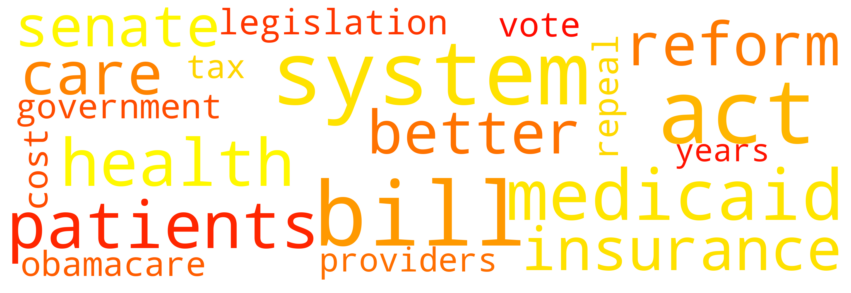

In [70]:
word_could_dict = Counter(predominant_rep_healthcare)
wordcloud = WordCloud(colormap='autumn',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

(-0.5, 2999.5, 999.5, -0.5)

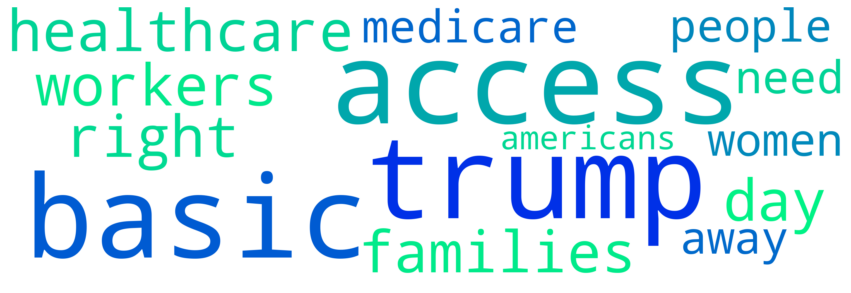

In [71]:
word_could_dict = Counter(predominant_dem_healthcare)
wordcloud = WordCloud(colormap='winter',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

## Climate change

In [72]:
predominant_rep_climate = getPredominantWordsByPart(rep_party,chunks_climate, chunk_class_climate, test_size)

Accuracy: 0.9263803680981595
Predominant Words for republicans :
['kentucky', 'solution', 'nuclear', 'deal', 'think', 'coal', 'methane', 'believe', 'one', 'industry', 'iran', 'war', 'like', 'would', 'real', 'production', 'south', 'oil']


In [73]:
predominant_dem_climate = getPredominantWordsByPart(dem_party,chunks_climate, chunk_class_climate, test_size)

Accuracy: 0.9263803680981595
Predominant Words for democrats :
['act', 'health', 'california', 'public', 'fight', 'trump', 'companies', 'address', 'people', 'communities', 'administration', 'country', 'make', 'action', 'science', 'crisis', 'change', 'clean', 'climate']


(-0.5, 2999.5, 999.5, -0.5)

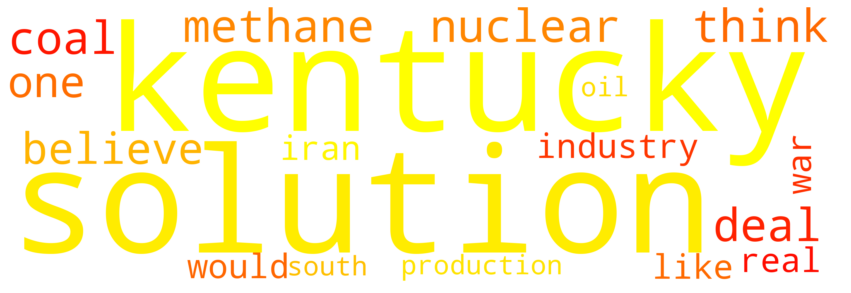

In [74]:
word_could_dict = Counter(predominant_rep_climate)
wordcloud = WordCloud(colormap='autumn',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

(-0.5, 2999.5, 999.5, -0.5)

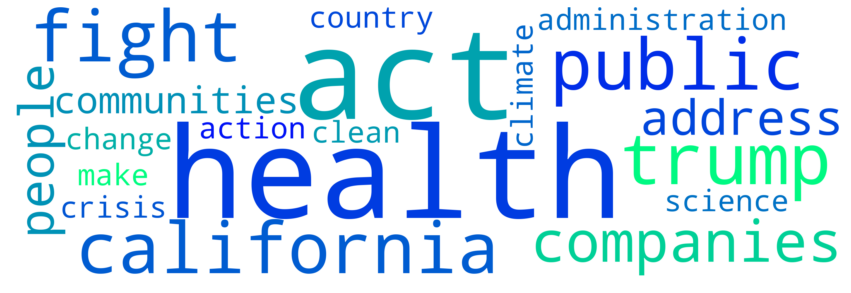

In [75]:
word_could_dict = Counter(predominant_dem_climate)
wordcloud = WordCloud(colormap='winter',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

## Gun policy

In [76]:
predominant_rep_gunpolicy = getPredominantWordsByPart(rep_party,chunks_gunpolicy, chunk_class_gunpolicy, test_size)

Accuracy: 0.9609375
Predominant Words for republicans :
['government', 'rifle', 'right', 'abiding', 'guns', 'amendment', 'law', 'criminals', 'firearm', 'would', 'laws', 'second', 'citizens', 'control']


In [77]:
predominant_dem_gunpolicy = getPredominantWordsByPart(dem_party,chunks_gunpolicy, chunk_class_gunpolicy, test_size)

Accuracy: 0.9609375
Predominant Words for democrats :
['families', 'weapons', 'common', 'nra', 'sense', 'lobby', 'legislation', 'epidemic', 'violence', 'must', 'communities', 'prevention', 'pass', 'take', 'us', 'congress', 'need', 'action', 'safety']


(-0.5, 2999.5, 999.5, -0.5)

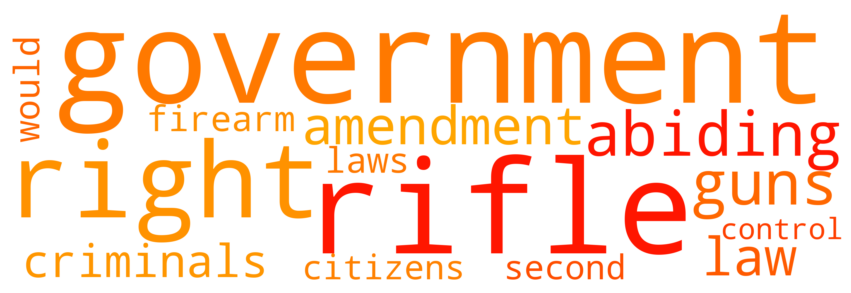

In [78]:
word_could_dict = Counter(predominant_rep_gunpolicy)
wordcloud = WordCloud(colormap='autumn',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

(-0.5, 2999.5, 999.5, -0.5)

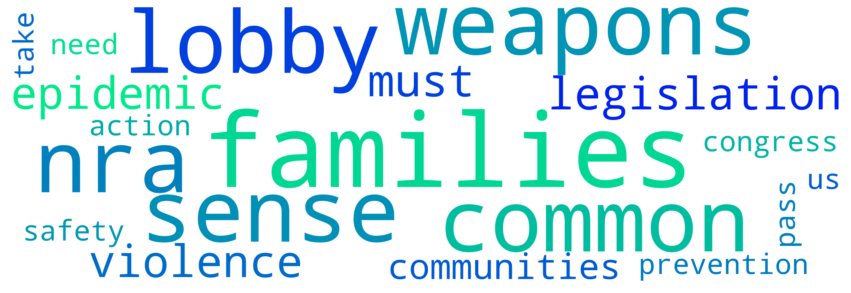

In [79]:
word_could_dict = Counter(predominant_dem_gunpolicy)
wordcloud = WordCloud(colormap='winter',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

## Immigration


In [80]:
predominant_rep_imm = getPredominantWordsByPart(rep_party,chunks_imm, chunk_class_imm, test_size)

Accuracy: 0.9665809768637532
Predominant Words for republicans :
['obama', 'time', 'daca', 'legislation', 'system', 'tax', 'one', 'broken', 'america', 'law', 'senate', 'border', 'laws', 'going', 'immigration', 'illegal', 'think', 'security']


In [81]:
predominant_dem_imm = getPredominantWordsByPart(dem_party,chunks_imm, chunk_class_imm, test_size)

Accuracy: 0.9665809768637532
Predominant Words for democrats :
['president', 'policies', 'children', 'military', 'detention', 'immigrants', 'rights', 'community', 'comprehensive', 'dreamers', 'communities', 'deportation', 'families', 'cruel', 'humanitarian', 'administration', 'immigrant', 'trump', 'wall']


(-0.5, 2999.5, 999.5, -0.5)

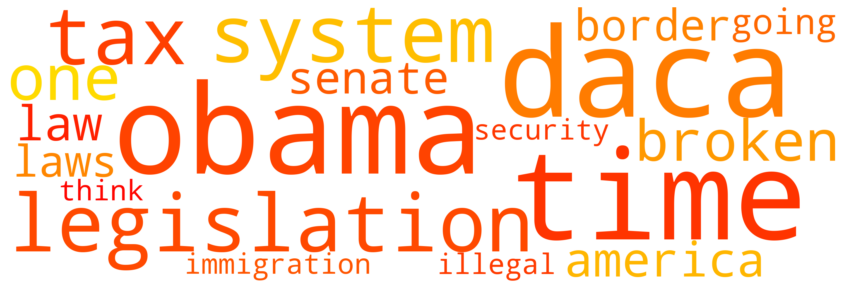

In [82]:
word_could_dict = Counter(predominant_rep_imm)
wordcloud = WordCloud(colormap='autumn',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

(-0.5, 2999.5, 999.5, -0.5)

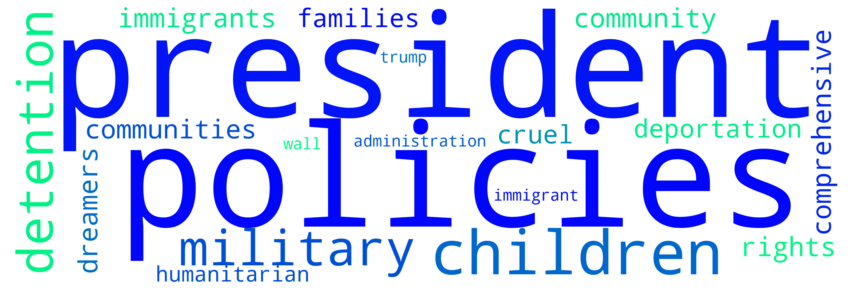

In [83]:
word_could_dict = Counter(predominant_dem_imm)
wordcloud = WordCloud(colormap='winter',background_color="white", width=3000, height=1000)\
                .generate_from_frequencies(word_could_dict)# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")

# 4. Immigration: analysis of non-neutral words

Number of quotes containing the word 'immigration' is 6018


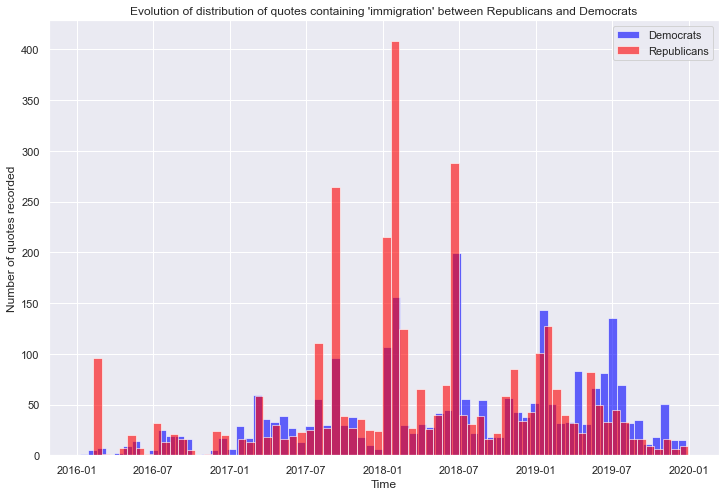

In [ ]:
# Select quotes that contain the word immigration
subject = 'immigration'
df_immigration = df[df['quotation'].str.contains(subject)]
print(f"Number of quotes containing the word \'{subject}\' is {df_immigration.shape[0]}")

# Plot distribution of quotes versus time for each party
ax = df_immigration["date"][df_immigration["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_immigration["date"][df_immigration["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Evolution of distribution of quotes containing 'immigration' between Republicans and Democrats")
ax.set(xlabel='Time', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()
ax.figure.savefig('DR_immigration_time.png')

Notice the peak at the beginning of year 2018...

In [ ]:
df_immigration[df_immigration["Year"]==2017]

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,date_of_birth,gender,state,Year


In [ ]:
#Percentage of quotes containing the word "immigration" per party 
count_total_quotes = [df.party.value_counts()['R'], df.party.value_counts()['D']] 
ratio_data = df_immigration['party'].value_counts()/count_total_quotes*100
ratio_data

R    0.635382
D    0.494722
Name: party, dtype: float64

It seems like the Republicans talk more about immigration than Democrats...

In [ ]:
# Next step is to produce a word cloud with the most common words

# Remove stop words using spacy
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# First wordcloud for Republicans

# Select quotes said by Republicans
df_quote_R = df_immigration[["quotation","party"]]
df_quote_R = df_quote_R[df_quote_R["party"]=="R"]

# Extract the most common words
docs_imm_R = {}
for index in range(df_quote_R.shape[0]):
    docs_imm_R[index] = nlp(df_quote_R.iloc[index]["quotation"])
    
all_common_words_imm_R = []

for index in range(df_quote_R.shape[0]):
    words = [token.text for token in docs_imm_R[index] if token.is_stop != True and token.is_punct != True]

    # five most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common()
    all_common_words_imm_R += common_words

# Transform list to dictionnary, "merge" duplicates
d_common_words_imm_R = defaultdict(list)
for key, value in all_common_words_imm_R:
    d_common_words_imm_R[key].append(value)    
d_common_words_imm_R = dict(zip(d_common_words_imm_R.keys(), [[sum(item)] for item in d_common_words_imm_R.values()]))

# Create a new dataframe from dictionnary and print most common words
df_common_words_imm_R = pd.DataFrame.from_dict(d_common_words_imm_R, orient='index', columns = ['Count'])
df_common_words_imm_R = df_common_words_imm_R.sort_values(['Count'], ascending=False)
df_common_words_imm_R["Word"] = df_common_words_imm_R.index.get_level_values(0)

df_common_words_imm_R.head(10)

,Count,Word
immigration,3767,immigration
border,878,border
system,736,system
illegal,719,illegal
people,473,people
security,462,security
President,406,President
country,403,country
think,397,think
reform,382,reform


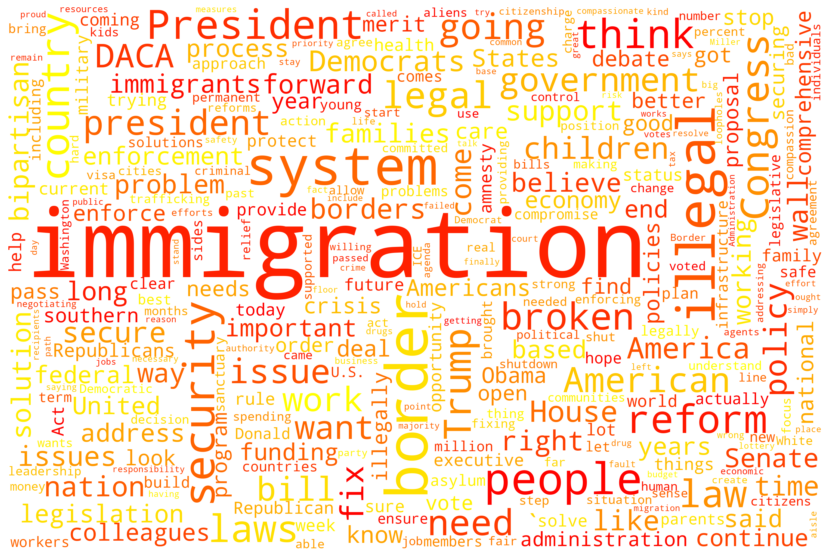

In [ ]:
# Generate word cloud
df_common_words_imm_R['Freq'] = df_common_words_imm_R['Count']/df_common_words_imm_R.shape[0]

# set max_words to 300
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(colormap='autumn',background_color="white", width=3000, height=2000, max_words=300)\
                      .generate_from_frequencies(df_common_words_imm_R['Freq'])# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")
plt.savefig('R_immigration_quotes_wc.png')

In [ ]:
# Repeat for Democrats now
df_quote_D = df_immigration[["quotation","party"]]
df_quote_D = df_quote_D[df_quote_D["party"]=="D"]

docs_imm_D = {}
for index in range(df_quote_D.shape[0]):
    docs_imm_D[index] = nlp(df_quote_D.iloc[index]["quotation"])
    
all_common_words_imm_D = []

for index in range(df_quote_D.shape[0]):
    words_imm_D = [token.text for token in docs_imm_D[index] if token.is_stop != True and token.is_punct != True]

    # five most common tokens
    word_freq_imm_D = Counter(words_imm_D)
    common_words_imm_D = word_freq_imm_D.most_common()
    all_common_words_imm_D += common_words_imm_D


d_common_words_imm_D = defaultdict(list)
for key, value in all_common_words_imm_D:
    d_common_words_imm_D[key].append(value)
    
d_common_words_imm_D = dict(zip(d_common_words_imm_D.keys(), [[sum(item)] for item in d_common_words_imm_D.values()]))


df_common_words_imm_D = pd.DataFrame.from_dict(d_common_words_imm_D, orient='index', columns = ['Count'])
df_common_words_imm_D = df_common_words_imm_D.sort_values(['Count'], ascending=False)
df_common_words_imm_D["Word"] = df_common_words_imm_D.index.get_level_values(0)

df_common_words_imm_D.head(10)

,Count,Word
immigration,2880,immigration
reform,632,reform
Trump,527,Trump
system,441,system
people,411,people
border,395,border
comprehensive,389,comprehensive
need,380,need
country,332,country
President,295,President


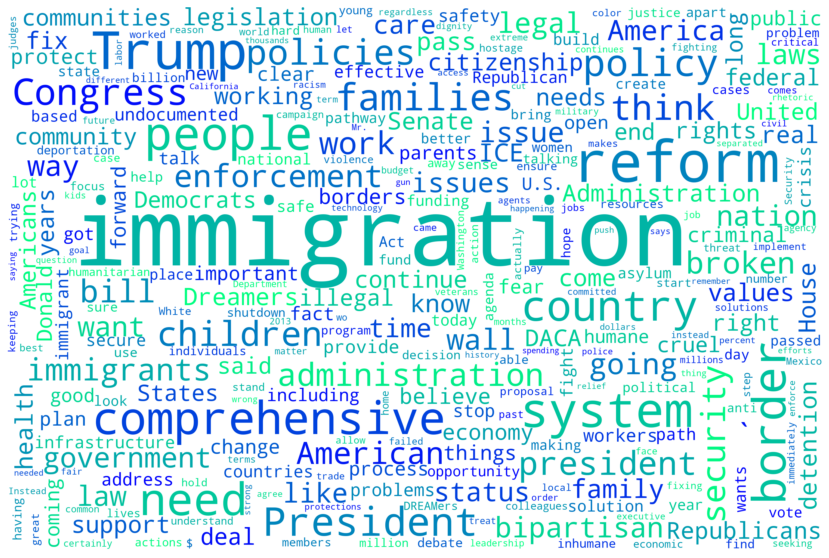

In [ ]:
# Generate word cloud for Democrats
df_common_words_imm_D['Freq'] = df_common_words_imm_D['Count']/df_common_words_imm_D.shape[0]

# set max_words to 300
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(colormap='winter',background_color="white", width=3000, height=2000, max_words=300)\
                      .generate_from_frequencies(df_common_words_imm_D['Freq'])# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")
plt.savefig('R_immigration_quotes_wc.png')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fzhan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-14-d8e45676ba47>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_immigration['sentiment_score'] = temp_compound


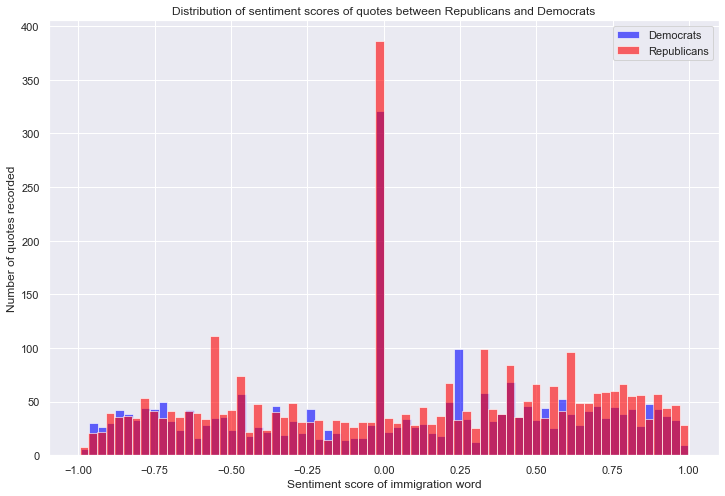

In [ ]:
# Use natural language toolkit analyser to see if there is any difference between R and D
nltk.download('vader_lexicon')

temp_compound = []
toscore = df_immigration['quotation'].str.lower().tolist()

# Only retrieve "compound" for each quote
for i in range(len(toscore)):
  temp_compound += [SentimentIntensityAnalyzer().polarity_scores(toscore[i]).get('compound')]

df_immigration['sentiment_score'] = temp_compound

# Plot distribution of sentiment score for each party
ax = df_immigration["sentiment_score"][df_immigration["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_immigration["sentiment_score"][df_immigration["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of quotes between Republicans and Democrats")
ax.set(xlabel='Sentiment score of immigration word', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()
ax.figure.savefig('DR_immigration_sentiment.png')

In [ ]:
# Test if the difference is significant
stats.ttest_ind(df_immigration["sentiment_score"][df_immigration["party"]=="D"], df_immigration["sentiment_score"][df_immigration["party"]=="R"])

Ttest_indResult(statistic=-1.9483450361014987, pvalue=0.0514202196393359)

Cannot reject the null hypothesis with a confidence interval of 95%, BUT distribution was not checked to be normal and cannot be sure that two distributions are independant. Considering the high number of quotes that were categorised as neutral, a deeper analysis will conducted focusing on non-neutral words

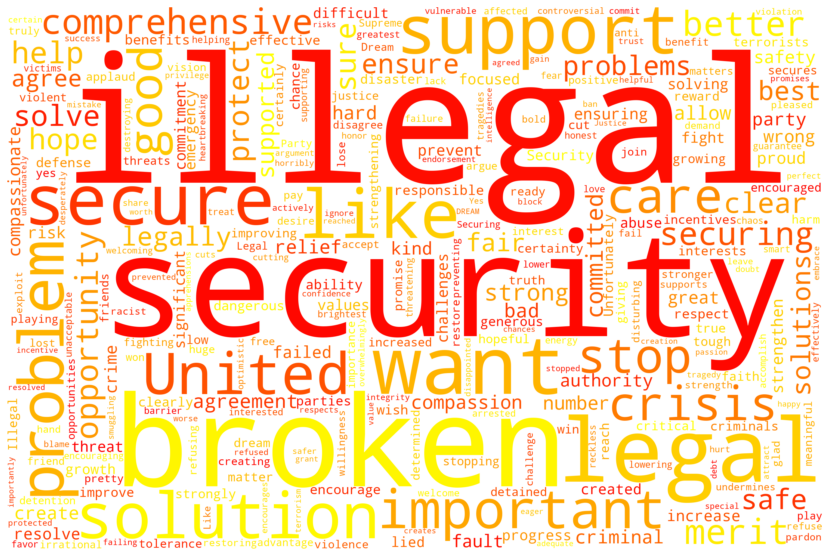

In [ ]:
#Compute sentiment score for most common words
temp_compound = []
toscore = df_common_words_imm_R['Word'].str.lower().tolist()

# Only retrieve "compound" for each quote
for i in range(len(toscore)):
  temp_compound += [SentimentIntensityAnalyzer().polarity_scores(toscore[i]).get('compound')]

df_common_words_imm_R['sentiment_score'] = temp_compound


# Create a new df removing the neutral words according to nltk
df_common_words_imm_R = df_common_words_imm_R.sort_values(by=['Count','sentiment_score'], ascending=False)
df_common_words_imm_R_new = df_common_words_imm_R[df_common_words_imm_R["sentiment_score"]!=0]

# take the 300 most frequent words
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(colormap='autumn',background_color="white", width=3000, height=2000, max_words=300)\
                      .generate_from_frequencies(df_common_words_imm_R_new['Freq'])# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")
plt.savefig('R_immigration_wc.png')

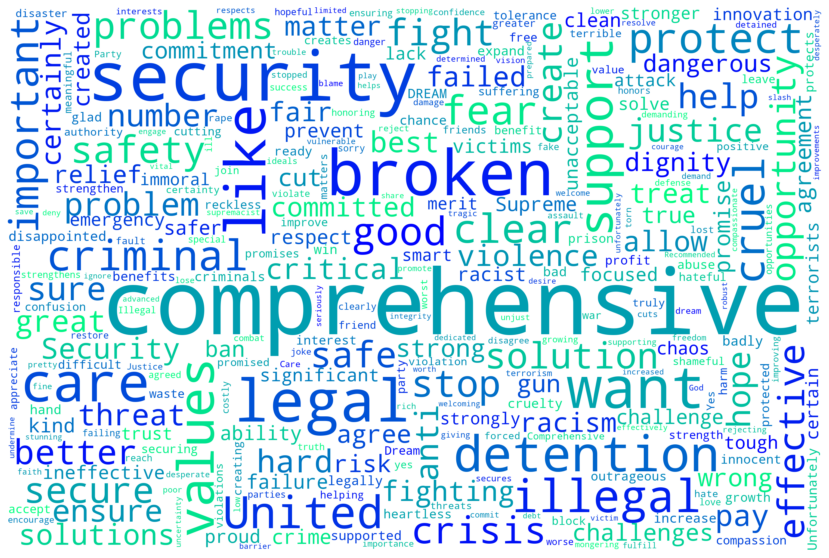

In [ ]:
#Compute sentiment score for most common words
temp_compound = []
toscore = df_common_words_imm_D['Word'].str.lower().tolist()

# Only retrieve "compound" for each quote
for i in range(len(toscore)):
  temp_compound += [SentimentIntensityAnalyzer().polarity_scores(toscore[i]).get('compound')]

df_common_words_imm_D['sentiment_score'] = temp_compound


# Create a new df removing the neutral words according to nltk
df_common_words_imm_D = df_common_words_imm_D.sort_values(by=['Count','sentiment_score'], ascending=False)
df_common_words_imm_D_new = df_common_words_imm_D[df_common_words_imm_D["sentiment_score"]!=0]

# take the 300 most frequent words
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(colormap='winter',background_color="white", width=3000, height=2000, max_words=300)\
                      .generate_from_frequencies(df_common_words_imm_D_new['Freq'])# set the word color to black

plt.figure(figsize=[15,10])# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
plt.axis("off")
plt.savefig('D_immigration_wc.png')

In [ ]:
df_common_words_imm_R_new.head(10)

,Count,Word,Freq,sentiment_score
illegal,719,illegal,0.106582,-0.5574
security,462,security,0.068485,0.3400
broken,346,broken,0.051290,-0.4767
legal,341,legal,0.050548,0.1280
want,277,want,0.041061,0.0772
secure,205,secure,0.030388,0.3400
support,193,support,0.028610,0.4019
like,192,like,0.028461,0.3612
solution,170,solution,0.025200,0.3182
problem,163,problem,0.024162,-0.4019


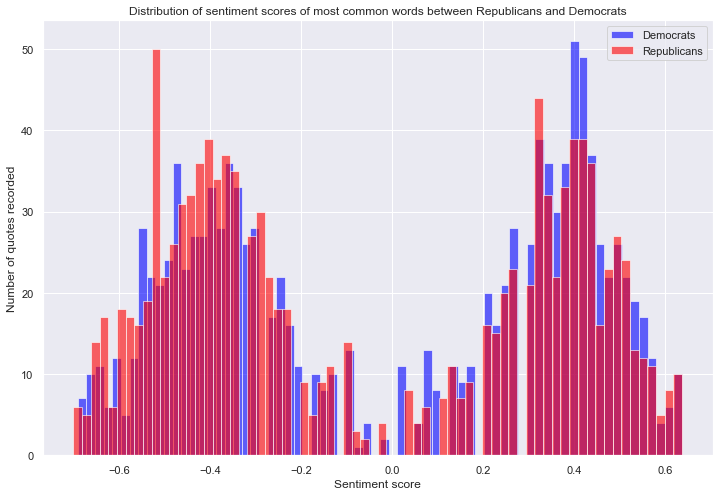

In [ ]:
# Plot distribution of sentiment score for most common words of each party
ax = df_common_words_imm_R_new["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_common_words_imm_D_new["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of most common words between Republicans and Democrats")
ax.set(xlabel='Sentiment score', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()
ax.figure.savefig('DR_immigration_sentiment_word.png')

# 5. Climate change and sentiment analysis on whole quotes

Number of quotes containing the word 'climate' is 4501


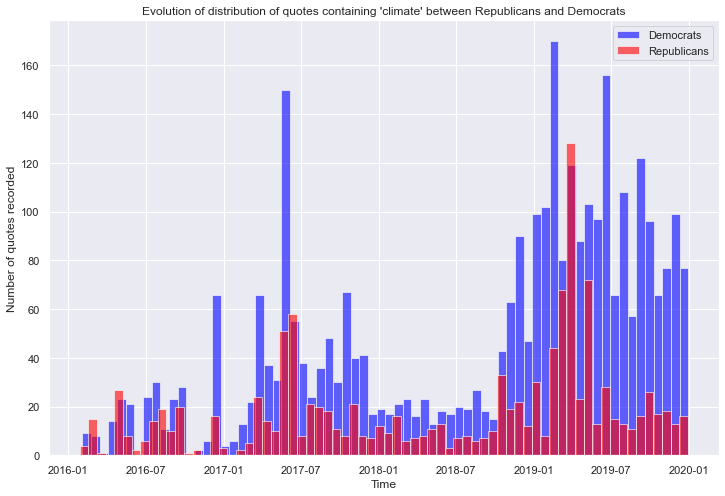

In [ ]:
#Retrieve quotes that contain climate and plot distribution
subject = 'climate'
df_climate = df[df['quotation'].str.contains(subject)]
print(f"Number of quotes containing the word \'{subject}\' is {df_climate.shape[0]}")

ax = df_climate["date"][df_climate["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_climate["date"][df_climate["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Evolution of distribution of quotes containing 'climate' between Republicans and Democrats")
ax.set(xlabel='Time', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()
ax.figure.savefig('DR_climate_year.png')

Notice the higher count values for Democrats...

In [ ]:
#Ratio of climate quotes for each party 
count_total_quotes = [df.party.value_counts()['D'], df.party.value_counts()['R']] 
ratio_data = df_climate['party'].value_counts()/count_total_quotes*100
ratio_data

D    0.616665
R    0.226424
Name: party, dtype: float64

In [ ]:
# Generate sentiment score
temp_compound = []
toscore = df_climate['quotation'].str.lower().tolist()


for i in range(len(toscore)):
  temp_compound += [SentimentIntensityAnalyzer().polarity_scores(toscore[i]).get('compound')]

df_climate['sentiment_score'] = temp_compound

<ipython-input-22-824c782415a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate['sentiment_score'] = temp_compound


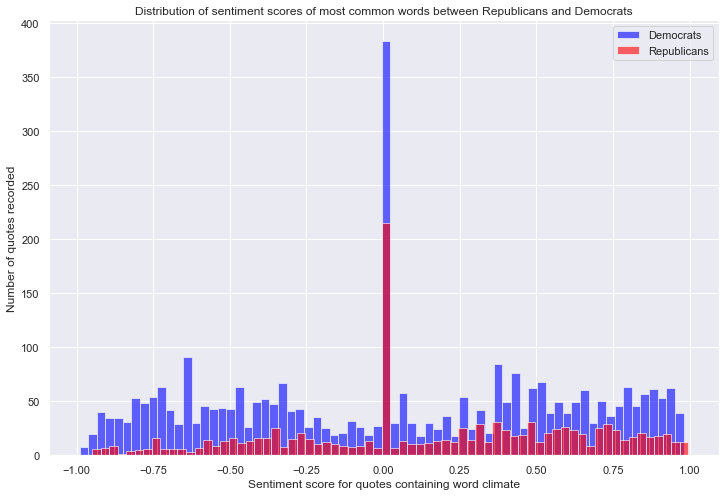

In [ ]:
# Plot distribution of sentiment score for climate quotes of each party
ax = df_climate["sentiment_score"][df_climate["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_climate["sentiment_score"][df_climate["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of most common words between Republicans and Democrats")
ax.set(xlabel='Sentiment score for quotes containing word climate', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()
ax.figure.savefig('DR_climate_sentiment.png')

[]

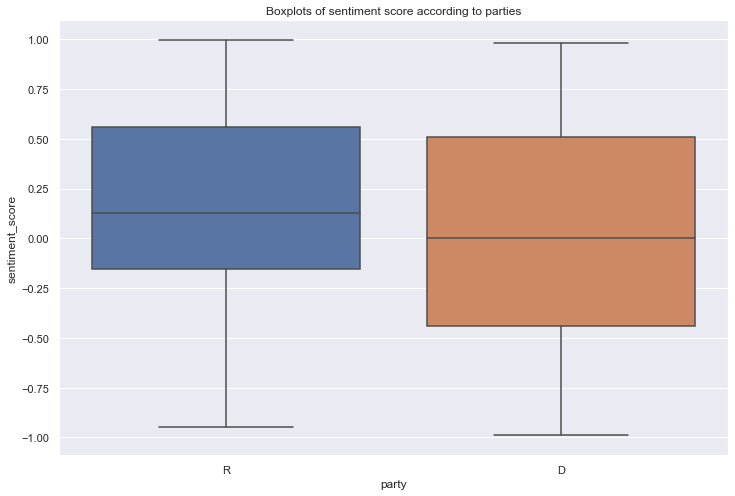

In [ ]:
ax = sns.boxplot(x="party", y="sentiment_score", data=df_climate)
ax.set_title('Boxplots of sentiment score according to parties')
plt.plot() 

In [ ]:
# Generate statistical values for Democrat sentiment score
df_climate["sentiment_score"][df_climate["party"]=="D"].describe()

count    3282.000000
mean        0.036590
std         0.554265
min        -0.990300
25%        -0.440400
50%         0.000000
75%         0.510600
max         0.980600
Name: sentiment_score, dtype: float64

In [ ]:
# The sentiment scores appear suspicious, have a look at the most positive and most negative quotes for Democrats
pd.set_option('display.max_colwidth', None)
print(df_climate["quotation"][df_climate["sentiment_score"]==0.980600])
print(df_climate["quotation"][df_climate["sentiment_score"]==-0.990300])

846983    Who is this economy really working for? It's doing great for thinner and thinner slice at the top. It's doing great for giant drug companies It's not doing great for people who are trying to get a prescription filled... It's doing great for giant oil companies... just not for the rest of us who are watching climate change bear down upon us... When you have an economy that does great for those that have money and isn't doing great for everyone else, that is corruption plain and simple...
Name: quotation, dtype: object
258115    Donald Trump and his children said just a few years ago that climate change was `irrefutable' and its consequences `catastrophic and irreversible.' They were right. There is no denying the growing threat of rising seas, warming global temperatures, and melting glaciers and ice sheets. But we can still avoid the worst if we quickly reduce carbon emissions. That is why ignoring reality and leaving the Paris Agreement could do down as one of the worst fore

Having a look at the most extreme quotes, the supposed most positive one does not appear to have a strong positive message, from our perspective as humans. This questions the efficiency of NLTK on quotes.

# 5. Generalisation to more themes, using lexical fields

In [ ]:
# Creation of function to generalise the process

def quotes_analysis(lex_field,subject):
    
    #Retrieve quotes that contain a certain lexical field and plot distribution for both parties
    df_subject = df[df['quotation'].str.contains('|'.join(lex_field))]
    print(f"Number of quotes around the word \'{subject}\' is {df_subject.shape[0]}")

    ax = df_subject["date"][df_subject["party"]=="D"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
    ax = df_subject["date"][df_subject["party"]=="R"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

    plt.title("Evolution of distribution of quotes containing %s between Republicans and Democrats" %subject)
    ax.set(xlabel='Time', ylabel='Number of quotes recorded')
    ax.legend(['Democrats','Republicans'])
    plt.show()
    ax.figure.savefig(subject + '.png')
    
    #Compute the percentage of subject quotes for each party 
    count_total_quotes = []
    count_total_quotes = [df.party.value_counts()['D'], df.party.value_counts()['R']] 
    ratio_data = df_subject['party'].value_counts()/count_total_quotes*100
    print("Percentage of quotes that contains the word %s :" %subject)
    print(ratio_data)
    
    return df_subject

In [ ]:
def word_clouds(df_subject,party):
    
    # Remove stopwords
    if party == 'R':
        word_color = 'autumn'
    else:
        word_color = 'winter'
    
    df_quote_P = df_subject[["quotation","party"]]
    df_quote_P = df_quote_P[df_quote_P["party"]==party]

    docs_subject_P = {}
    for index in range(df_quote_P.shape[0]):
        docs_subject_P[index] = nlp(df_quote_P.iloc[index]["quotation"])
    
    all_common_words_subject_P = []

    for index in range(df_quote_P.shape[0]):
        words = [token.text for token in docs_subject_P[index] if token.is_stop != True and token.is_punct != True]

        # five most common tokens
        word_freq = Counter(words)
        common_words = word_freq.most_common()
        all_common_words_subject_P += common_words

    d_common_words_subject_P = defaultdict(list)
    for key, value in all_common_words_subject_P:
        d_common_words_subject_P[key].append(value)
    
    d_common_words_subject_P = dict(zip(d_common_words_subject_P.keys(), [[sum(item)] for item in d_common_words_subject_P.values()]))

    df_common_words_subject_P = pd.DataFrame.from_dict(d_common_words_subject_P, orient='index', columns = ['Count'])
    df_common_words_subject_P = df_common_words_subject_P.sort_values(['Count'], ascending=False)
    df_common_words_subject_P["Word"] = df_common_words_subject_P.index.get_level_values(0)

    df_common_words_subject_P['Freq'] = df_common_words_subject_P['Count']/df_common_words_subject_P.shape[0]


    # Generate sentiment score and remove neutral words
    temp_compound = []
    toscore = df_common_words_subject_P['Word'].str.lower().tolist()

    for i in range(len(toscore)):
        temp_compound += [SentimentIntensityAnalyzer().polarity_scores(toscore[i]).get('compound')]

    df_common_words_subject_P['sentiment_score'] = temp_compound

    df_common_words_subject_P = df_common_words_subject_P.sort_values(by=['Count','sentiment_score'], ascending=False)
    df_common_words_subject_P_new = df_common_words_subject_P[df_common_words_subject_P["sentiment_score"]!=0]
    
    # Generate word cloud
    # set max_words to 300
    # set width and height to higher quality, 3000 x 2000
    wordcloud = WordCloud(colormap=word_color,background_color="white", width=3000, height=2000, max_words=300)\
                      .generate_from_frequencies(df_common_words_subject_P_new['Freq'])# set the word color to black

    plt.figure(figsize=[15,10])# plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")# remove plot axes
    plt.axis("off")
    plt.savefig(subject + 'wc.png')
    
    return df_common_words_subject_P_new

## A) Immigration

Number of quotes around the word 'immigration' is 1977


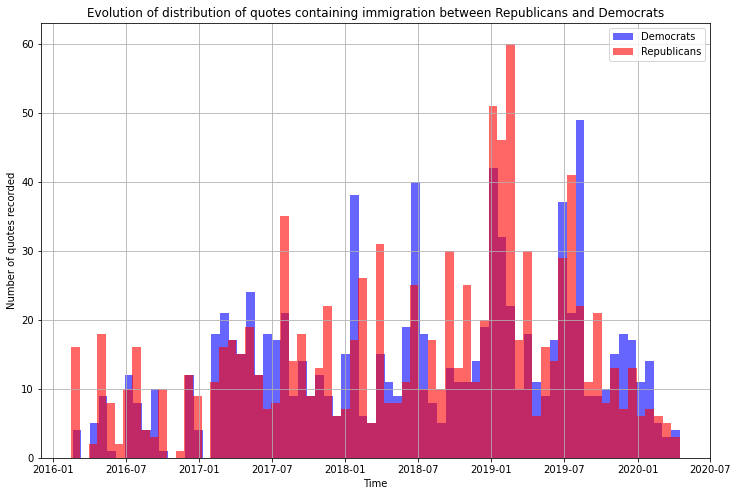

Percentage of quotes that contains the word immigration :
R    0.179625
D    0.165239
Name: party, dtype: float64


In [ ]:
lex_field_imm = ["Immigration","Immigrant","Immigrate","Influx of immigrants","First generation immigrant","Immigrant Community/Population",
                 "Migrant","Economic Migrant","Flood of Migrants","Chain Migration","Voluntary Migration","Forced migration",
                 "International Migration","Interregional Migration","Migration","Migrant Labor","Emigration","Permanent Resident",
                 "Temporary Resident","Undocumented","Illegal immigrant","Repatriation","Resettlement","Colonization", "Refugee", 
                 "Refugee Status", "Refugee Crisis", "Refugee Claimant", "Resettled Refugee", "Refugee Camp", "Political Refugee", 
                 "Economic Refugee", "Refugee Flow", "UNHCR (United Nations High Commissioner for Refugees)", "Internally Displaced Person", 
                 "Asylum", "An Asylum-Seeker", "Stateless person", "Humanitarian", "Aid", "Flee", "Terror", "Human rights", "Border", "Barrier", 
                 "Smuggling", "Trafficker", "Deportation"]

df_imm = quotes_analysis(lex_field_imm,'immigration')


In [ ]:
df_common_words_imm_R_nltk = word_clouds(df_imm,'R')
df_common_words_imm_D_nltk = word_clouds(df_imm,'D')

In [ ]:
print(df_common_words_imm_R_nltk.head(10))
print(df_common_words_imm_D_nltk.head(10))

           Count       Word      Freq  sentiment_score
security     168   security  0.033546           0.3400
illegal       70    illegal  0.013978          -0.5574
support       63    support  0.012580           0.4019
United        52     United  0.010383           0.4215
important     51  important  0.010184           0.2023
Security      50   Security  0.009984           0.3400
Terrorism     50  Terrorism  0.009984          -0.6808
secure        46     secure  0.009185           0.3400
help          45       help  0.008986           0.4019
like          44       like  0.008786           0.3612
           Count       Word      Freq  sentiment_score
like          52       like  0.010484           0.3612
United        49     United  0.009879           0.4215
security      48   security  0.009677           0.3400
support       42    support  0.008468           0.4019
Security      42   Security  0.008468           0.3400
want          39       want  0.007863           0.0772
Terrorism 

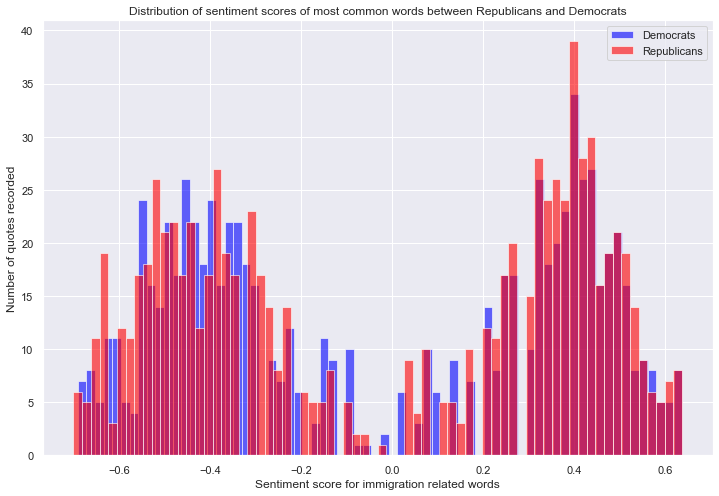

In [ ]:
# Plot distribution of sentiment score for most common words of each party
ax = df_common_words_imm_D_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_common_words_imm_R_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of most common words between Republicans and Democrats")
ax.set(xlabel='Sentiment score for immigration related words', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()

## B) Climate Change

Number of quotes around the word 'climate' is 5844


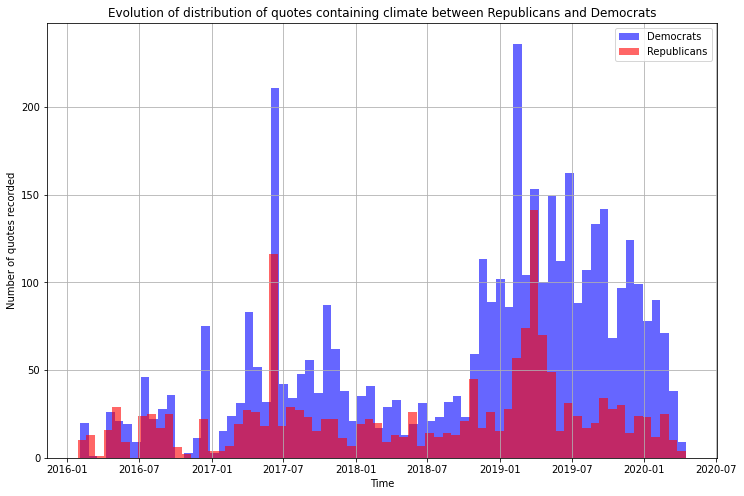

Percentage of quotes that contains the word climate :
D    0.718155
R    0.288814
Name: party, dtype: float64


In [ ]:
lex_field_climate = ["climate",
                        "climate change",
                        "Fossil Fuel",
                         "Coal",
                         "Oil",
                         "Greenhouse Gas",
                         "Carbon Dioxide",
                         "Ozone",
                         "Global Warming",
                         "Greenhouse effect",
                         "Extreme Weather Event",
                         "Carbon Footprint",
                         "Adaptation",
                         "Mitigation",
                         "Pollutant",
                         "Drought" ,
                         "Renewable Resource",
                         "Climate",
                         "Habitat",
                         "Ecosystem",
                         "Weather",
                         "Precipitation",
                         "Global climate",
                         "Methane"]

df_climate = quotes_analysis(lex_field_climate,'climate')


In [ ]:
df_common_words_clim_R_nltk = word_clouds(df_climate,'R')
df_common_words_clim_D_nltk = word_clouds(df_climate,'D')

In [ ]:
print(df_common_words_clim_R_nltk.head(10))
print(df_common_words_clim_D_nltk.head(10))

           Count       Word      Freq  sentiment_score
energy       134     energy  0.023422           0.2732
like         103       like  0.018004           0.3612
United        69     United  0.012061           0.4215
agreement     59  agreement  0.010313           0.4939
want          59       want  0.010313           0.0772
support       57    support  0.009963           0.4019
solutions     51  solutions  0.008915           0.1779
great         49      great  0.008565           0.6249
good          49       good  0.008565           0.4404
protect       47    protect  0.008215           0.3818
          Count      Word      Freq  sentiment_score
crisis      444    crisis  0.053148          -0.6249
energy      339    energy  0.040579           0.2732
threat      243    threat  0.029088          -0.5267
clean       232     clean  0.027771           0.4019
like        218      like  0.026095           0.3612
want        161      want  0.019272           0.0772
fight       158     figh

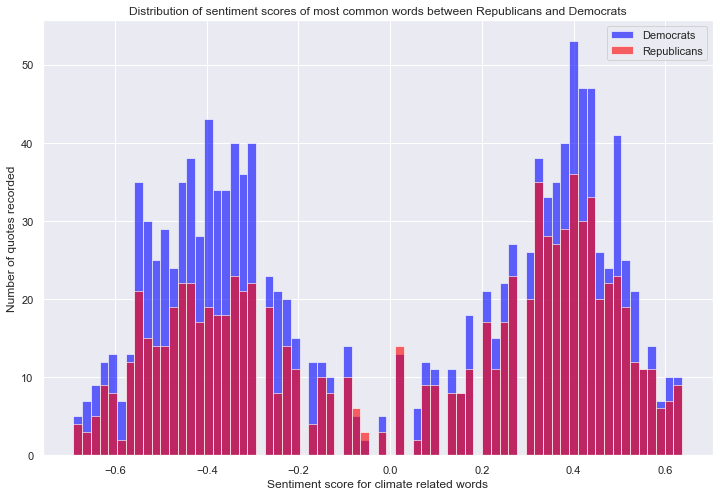

In [ ]:
# Plot distribution of sentiment score for most common words of each party
ax = df_common_words_clim_D_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_common_words_clim_R_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of most common words between Republicans and Democrats")
ax.set(xlabel='Sentiment score for climate related words', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()

## C) Gun policy

Number of quotes around the word 'gun policy' is 10113


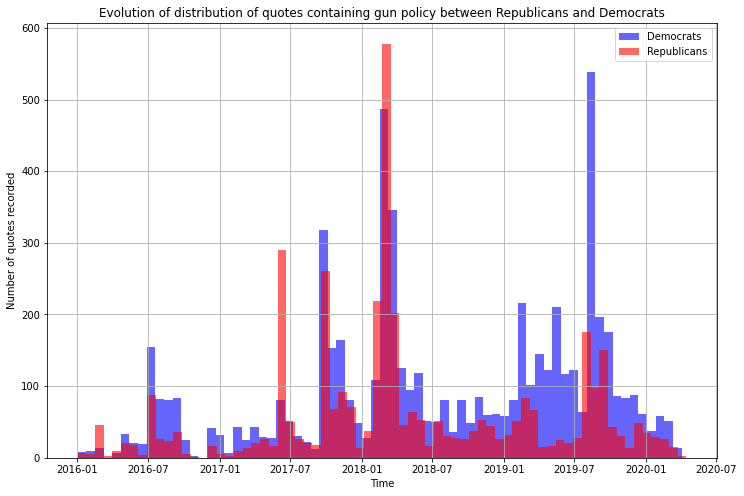

Percentage of quotes that contains the word gun policy :
D    1.077405
R    0.678687
Name: party, dtype: float64


In [ ]:
# Gun policy
lex_field_gunpolicy = ["gunlaw",
                        "gun policy",
                        "gun violence",
                        "gun control",
                        "gun license",
                        "gun",                        
                        "firearm",
                        "rifle",
                        "revolver",
                        "gun ownership",
                        "gun debate",
                        "gun law",
                        "firearms regulation"
                        ]

df_gun = quotes_analysis(lex_field_gunpolicy,'gun policy')


In [ ]:
df_common_words_gun_R_nltk = word_clouds(df_gun,'R')
df_common_words_gun_D_nltk = word_clouds(df_gun,'D')

In [ ]:
print(df_common_words_gun_R_nltk.head(10))
print(df_common_words_gun_D_nltk.head(10))

           Count       Word      Freq  sentiment_score
gun         2181        gun  0.276812          -0.3400
violence     381   violence  0.048356          -0.6249
like         276       like  0.035030           0.3612
want         260       want  0.032999           0.0772
support      215    support  0.027288           0.4019
criminals    156  criminals  0.019799          -0.5719
prevent      149    prevent  0.018911           0.0258
problem      138    problem  0.017515          -0.4019
stop         117       stop  0.014850          -0.2960
ban          115        ban  0.014596          -0.5574
          Count      Word      Freq  sentiment_score
gun        4994       gun  0.518749          -0.3400
violence   2251  violence  0.233822          -0.6249
safety      700    safety  0.072712           0.4215
weapons     387   weapons  0.040199          -0.4404
like        362      like  0.037603           0.3612
want        333      want  0.034590           0.0772
assault     248   assaul

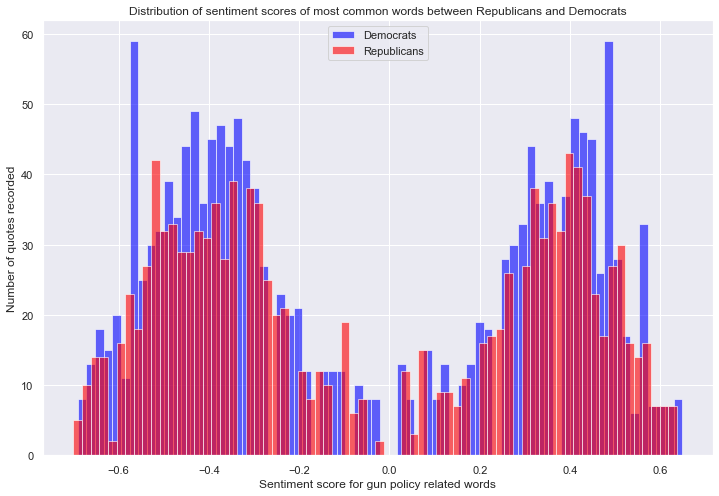

In [ ]:
# Plot distribution of sentiment score for most common words of each party
ax = df_common_words_gun_D_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_common_words_gun_R_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of most common words between Republicans and Democrats")
ax.set(xlabel='Sentiment score for gun policy related words', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()

## D) Healthcare

Number of quotes around the word 'healthcare' is 18518


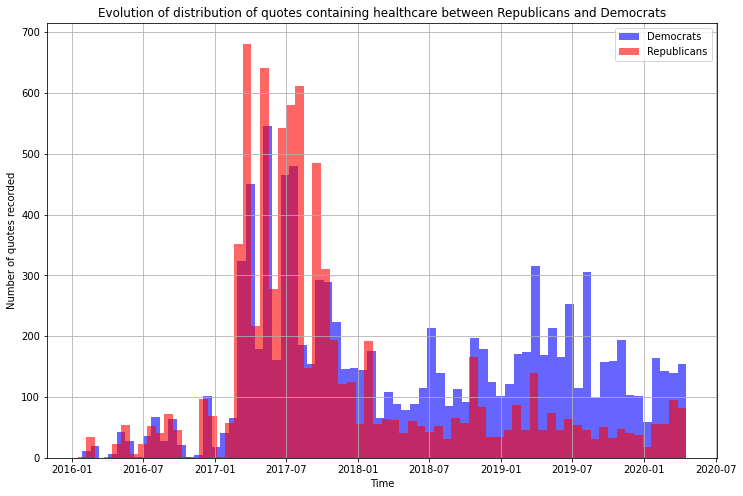

Percentage of quotes that contains the word healthcare :
D    1.76202
R    1.45471
Name: party, dtype: float64


In [ ]:
# Healthcare
lex_field_healthcare = ["healthcare",
                        "health care",
                        "health insurance",
                        "health maintenance",
                        "social insurance",
                        "medicare",
                        "medicaid",
                        "obamacare",
                        "affordable care act",
                        "patient protection",
                        "healthcare system",
                        "insurance coverage"                        
                        ]
df_health = quotes_analysis(lex_field_healthcare,'healthcare')


In [ ]:
df_common_words_health_R_nltk = word_clouds(df_health,'R')
df_common_words_health_D_nltk =word_clouds(df_health,'D')

In [ ]:
print(df_common_words_health_R_nltk.head(10))
print(df_common_words_health_D_nltk.head(10))

           Count       Word      Freq  sentiment_score
care        6253       care  0.632831           0.4939
want         668       want  0.067604           0.0772
like         482       like  0.048780           0.3612
better       469     better  0.047465           0.4404
help         399       help  0.040381           0.4019
important    386  important  0.039065           0.2023
lower        373      lower  0.037749          -0.2960
Care         339       Care  0.034308           0.4939
support      310    support  0.031373           0.4019
best         277       best  0.028034           0.6369
         Count     Word      Freq  sentiment_score
care      8168     care  0.699914           0.4939
like       587     like  0.050300           0.3612
want       585     want  0.050129           0.0772
Care       490     Care  0.041988           0.4939
pay        429      pay  0.036761          -0.1027
fight      422    fight  0.036161          -0.3818
help       403     help  0.034533     

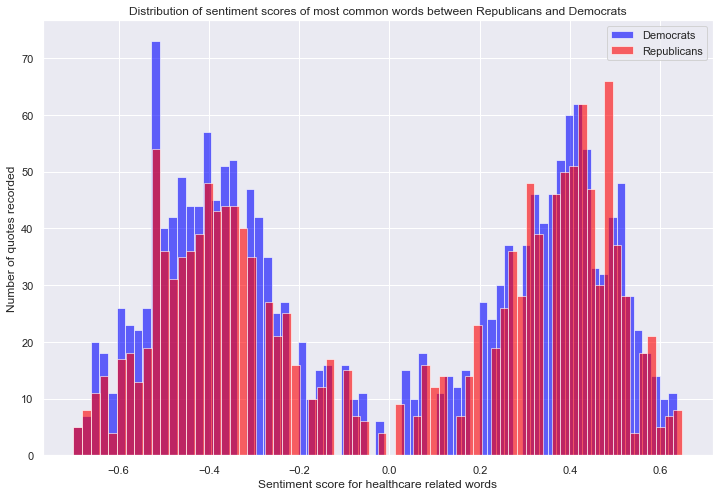

In [ ]:
# Plot distribution of sentiment score for most common words of each party
ax = df_common_words_health_D_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="blue")
ax = df_common_words_health_R_nltk["sentiment_score"].hist(bins = 70, figsize=(12,8),alpha = 0.6, color="red")

plt.title("Distribution of sentiment scores of most common words between Republicans and Democrats")
ax.set(xlabel='Sentiment score for healthcare related words', ylabel='Number of quotes recorded')
ax.legend(['Democrats','Republicans'])
plt.show()

In [ ]:
## take all quotations independent of party or speaker
quotations = np.array(df["quotation"])
print(len(quotations))

1158013


# 6. Positive & Negative Quotes ratio



In [ ]:
lexical_field_str = ["healthcare", "gun policy", "climate change", "immigration"]

def plotSentimentAnalysis(lex_field, idx_lf):
  # Lowercase conversion
  lex_field = np.array([x.lower() if isinstance(x, str) else x for x in lex_field])
  # Retrieve quotes 
  set_lf = set(lex_field)
  lf_quotations = [quote for quote in quotations if(set_lf.intersection(set(quote.split())))]

  # df of quotes only on 1 subject
  df_lf_quotations = pd.DataFrame(lf_quotations, index=range(len(lf_quotations)), columns = ['quotation']) 

  # Retrieve all other attributes (speaker, party,...) about the quote
  df_lf = df.merge(df_lf_quotations, on=['quotation'], 
                    how='left', indicator=True)

  # df containing only quotes (&attributes of the speaker) w.r.t to the subject chosen
  df_lf = df_lf[df_lf['_merge'] == 'both']

  # Sentiment Analysis

  analyzer = SentimentIntensityAnalyzer()
  def getSentimentAnalysis(dataset):
    return [analyzer.polarity_scores(quote)['compound'] for quote in lf_quotations]
  
  # Retrieve sentiment scores -1 to 1
  sent_quotations = getSentimentAnalysis(lf_quotations)

  # Select only positive and negative quotes (ignore neutral)
  df_neg_quotes = df_lf[np.array(sent_quotations) < -0.5]
  df_pos_quotes = df_lf[np.array(sent_quotations) > 0.5]

  #Count the number of positive and negative quotes for EACH PARTY
  df_pos_neg_party = pd.concat([df_pos_quotes.party.value_counts().to_frame('positive'), df_neg_quotes.party.value_counts().to_frame('negative')], axis=1)

  #Normalize horizontal histogram
  neg_data = df_pos_neg_party.apply(lambda x: x*100/sum(x),axis=1)
  neg_data.plot(kind="barh", stacked = True, color = ["limegreen", "tomato"])
  plt.title(f"{lexical_field_str[idx_lf]}")
  plt.xlabel("Percentage [%]")
  plt.ylabel("Attributes")
  plt.savefig(f'/content/drive/MyDrive/ADA/{lexical_field_str[idx_lf]}_nltk.png')
  plt.show()


In [ ]:
healthcare_idx = 0
gun_policy_idx = 1
climate_change_idx = 2
immigration_idx = 3

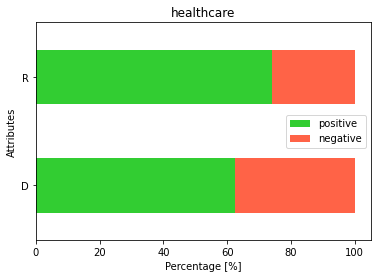

In [ ]:
plotSentimentAnalysis(lex_field_healthcare, healthcare_idx)

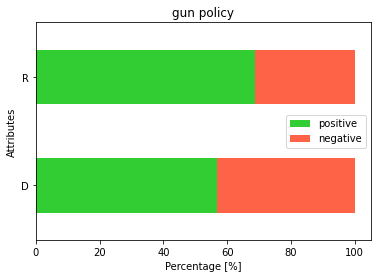

In [ ]:
plotSentimentAnalysis(lex_field_climate, gun_policy_idx)

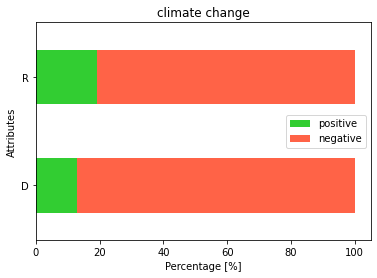

In [ ]:
plotSentimentAnalysis(lex_field_gunpolicy, climate_change_idx)

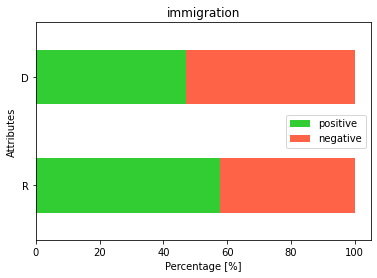

In [ ]:
plotSentimentAnalysis(lex_field_imm, immigration_idx)